### Data Preprocessing

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf

#### Cropping the images to remove background

In [2]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img

##### Creating a cropped folder in which cropped training and testing images are stored

In [3]:
if __name__ == "__main__":
	training = "archive/Training"
	testing = "archive/Testing"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256
	
	for dir in training_dir:
		save_path = 'Dataset/cropped/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'Dataset/cropped/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)


	

In [4]:
training_dir

['glioma', 'meningioma', 'notumor', 'pituitary']

##### Cropped images Demo 

In [5]:
# img = cv2.imread('./Dataset/Trainingbrain/meningioma/Tr-me_0476.jpg')
# img = cv2.resize(
#             img,
#             dsize=(224,224),
#             interpolation=cv2.INTER_CUBIC
#         )
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# gray = cv2.GaussianBlur(gray, (5, 5), 0)

# # threshold the image, then perform a series of erosions +
# # dilations to remove any small regions of noise
# thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
# thresh = cv2.erode(thresh, None, iterations=2)
# thresh = cv2.dilate(thresh, None, iterations=2)

# # find contours in thresholded image, then grab the largest one
# cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# c = max(cnts, key=cv2.contourArea)

# # find the extreme points
# extLeft = tuple(c[c[:, :, 0].argmin()][0])
# extRight = tuple(c[c[:, :, 0].argmax()][0])
# extTop = tuple(c[c[:, :, 1].argmin()][0])
# extBot = tuple(c[c[:, :, 1].argmax()][0])

# # add contour on the image
# img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# # add extreme points
# img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
# img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
# img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
# img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# # crop
# ADD_PIXELS = 0
# new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

In [6]:
# plt.figure(figsize=(15,6))
# plt.subplot(141)
# plt.imshow(img)
# plt.xticks([])
# plt.yticks([])
# plt.title('Step 1. Get the original image')
# plt.subplot(142)
# plt.imshow(img_cnt)
# plt.xticks([])
# plt.yticks([])
# plt.title('Step 2. Find the biggest contour')
# plt.subplot(143)
# plt.imshow(img_pnt)
# plt.xticks([])
# plt.yticks([])
# plt.title('Step 3. Find the extreme points')
# plt.subplot(144)
# plt.imshow(new_img)
# plt.xticks([])
# plt.yticks([])
# plt.title('Step 4. Crop the image')
# plt.show()

##### Creating X and Y variables

In [7]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 200
labels = ['glioma','meningioma','notumor','pituitary'] 
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Training',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_train.append(image)
        y_train.append(labels.index(i))
        
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Testing',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_test.append(image)
        y_test.append(labels.index(i))

X_train = np.array(X_train) / 255.0 # normalize Images into range 0 to 1.
X_test = np.array(X_test) / 255.0

print(X_train.shape)
print(X_test.shape)
        

(5712, 200, 200, 3)
(1311, 200, 200, 3)


(5712, 200, 200, 3) signifies the dimensions of the training dataset. 

- **5712**: This denotes the number of individual samples or images in the training set. Each sample serves as an instance for training the machine learning model.

- **200**: This indicates that each image has a width of 200 pixels. Resizing all images to this uniform width ensures compatibility and consistency when feeding them into a model.

- **200**: Similarly, this signifies the height of each image, also being 200 pixels. Having a consistent spatial size (width and height) is crucial for most machine learning and deep learning models.

- **3**: This represents the three color channels (Red, Green, Blue, or RGB) for each image. Despite initially reading the images in grayscale, the application of `cv2.applyColorMap` seems to have transformed them into color-mapped images with three channels, which is typical for colored images processed by models, especially convolutional neural networks (CNNs) that are designed to handle color information.

In summary, `X_train` is a four-dimensional array (or tensor) containing 5712 samples, each being a 200x200 pixel RGB image, well-suited for direct input into deep learning models for training.

In [8]:
# images = [X_train[i] for i in range(9)]
# fig, axes = plt.subplots(3, 3, figsize = (10, 10))
# axes = axes.flatten()
# for img, ax in zip(images, axes):
#     ax.imshow(img)
# #plt.tight_layout()
# plt.show()

### Train test split

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [10]:
X_train, y_train = shuffle(X_train,y_train, random_state=42) 

In [11]:
#One Hot Encoding on the labels
y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.
# print(X_val.shape)
# print(X_train.shape)
# print(X_test.shape)

### Image Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [14]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(X_train)

### Model Training

In [15]:
# from tensorflow.keras.applications.vgg19 import VGG19
# IMG_SIZE=(200,200)
# base_model = VGG19(
#     include_top=False,
#     input_shape=IMG_SIZE + (3,),
#     weights='imagenet')

# for layer in base_model.layers:
#     layer.trainable = True

# # Customized layers
# x = GlobalAveragePooling2D()(base_model.output)
# x = Dropout(0.4)(x)
# predict = Dense(4,activation='softmax')(x)

# # create a model object
# model = Model(inputs = base_model.input,outputs = predict)

# #compile our model.
# adam = Adam(learning_rate=0.0001)
# model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.model_selection import train_test_split

# # Federated Learning Parameters
# NUM_CLIENTS = 15
# NUM_ROUNDS = 2
# CLIENT_FRACTION = 0.5  # Fraction of clients participating in each round

# # Data Preparation (Assume X_train, y_train are prepared as per previous code)
# # X_train shape: (n_samples, 200, 200, 3)
# # y_train shape: (n_samples, 4) - one-hot encoded

# # Split data among clients
# def create_clients(X_train, y_train, num_clients=NUM_CLIENTS):
#     clients = []
#     data_per_client = len(X_train) // num_clients
    
#     for i in range(num_clients):
#         client_X = X_train[i*data_per_client : (i+1)*data_per_client]
#         client_y = y_train[i*data_per_client : (i+1)*data_per_client]
#         clients.append((client_X, client_y))
    
#     return clients

# clients = create_clients(X_train, y_train)

# # Initialize the global model
# def create_global_model():
#     IMG_SIZE = (200, 200)
#     base_model = VGG19(
#         include_top=False,
#         input_shape=IMG_SIZE + (3,),
#         weights='imagenet')

#     # Default: Freeze all layers
#     for layer in base_model.layers:
#         layer.trainable = False
#     for layer in base_model.layers[-7:]:
#         layer.trainable = True

#     # Custom classification head
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dropout(0.4)(x)
#     predict = Dense(4, activation='softmax')(x)

#     # Create the model
#     model = Model(inputs=base_model.input, outputs=predict)
    
#     # Compile the model
#     optimizer = Adam(learning_rate=0.0001)
#     model.compile(optimizer=optimizer, 
#                  loss='categorical_crossentropy', 
#                  metrics=['accuracy'])
    
#     return model

# # # Data augmentation configuration
# # datagen = ImageDataGenerator(
# #     rotation_range=10,
# #     width_shift_range=0.05,
# #     height_shift_range=0.05,
# #     horizontal_flip=True)
# # datagen.fit(X_train)

# # Federated Learning Main Loop
# global_model = None

# for round_num in range(NUM_ROUNDS):
#     print(f"\n=== Federated Learning Round {round_num + 1}/{NUM_ROUNDS} ===")
    
#     # 1. Initialize or copy the global model
#     if global_model is None:
#         print("Initializing global model...")
#         global_model = create_global_model()
#     else:
#         print("Using existing global model...")
    
#     # 2. Select clients
#     selected_client_indices = np.random.choice(
#         len(clients), 
#         size=int(NUM_CLIENTS * CLIENT_FRACTION), 
#         replace=False)
#     selected_clients = [clients[i] for i in selected_client_indices]
    
#     # Store client model weights
#     client_weights = []
    
#     # 3. Local training on clients
#     for client_idx, (client_X, client_y) in enumerate(selected_clients):
#         print(f"\nTraining Client {client_idx + 1}/{len(selected_clients)}...")
        
#         # Clone the global model
#         client_model = tf.keras.models.clone_model(global_model)
#         client_model.set_weights(global_model.get_weights())
        
#         # Compile the client model
#         client_model.compile(optimizer=Adam(learning_rate=0.0001),
#                            loss='categorical_crossentropy',
#                            metrics=['accuracy'])
        
#         # Local training
#         history = client_model.fit(
#             datagen.flow(client_X, client_y, batch_size=16),
#             epochs=5,
#             verbose=1)
        
#         # Save client weights
#         client_weights.append(client_model.get_weights())
    
#     # 4. Federated Averaging (FedAvg)
#     print("\nAggregating client model weights...")
#     global_weights = []
    
#     # Average weights layer by layer
#     for layer_idx in range(len(global_model.get_weights())):
#         layer_weights = np.array([weights[layer_idx] for weights in client_weights])
#         avg_layer_weights = np.mean(layer_weights, axis=0)
#         global_weights.append(avg_layer_weights)
    
#     # Update the global model
#     global_model.set_weights(global_weights)
    
#     # # 5. Evaluate the global model
#     # print("\nEvaluating the global model...")
#     # loss, accuracy = global_model.evaluate(X_test, y_test, verbose=0)
#     # print(f"Test Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

# # Save the final global model
# global_model.save('federated_vgg19_model2.h5')
# print("\nFederated learning completed. Model saved as federated_vgg19_model2.h5")

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

# Federated Learning Parameters
NUM_CLIENTS = 50
NUM_ROUNDS = 50
CLIENT_FRACTION = 0.5  # Fraction of clients participating in each round

# Early Stopping Parameters
WINDOW_SIZE = 3  # Number of rounds to consider for sliding window
MIN_DELTA = 0.002  # Minimum improvement to consider as progress
PATIENCE = 3  # Number of rounds with no improvement before stopping

# # 场景1：IID数据，快速收敛
# WINDOW_SIZE = 3   # 关注短期趋势
# MIN_DELTA = 0.003 # 忽略微小波动
# PATIENCE = 3      # 3轮不提升则停止

# # 场景2：Non-IID医疗数据，保守训练
# WINDOW_SIZE = 7   # 长窗口平滑异构性
# MIN_DELTA = 0.001 # 敏感检测微小改进
# PATIENCE = 5      # 允许更长平台期

# Data Preparation (Assume X_train, y_train, X_test, y_test are prepared)
# X_train shape: (n_samples, 200, 200, 3)
# y_train shape: (n_samples, 4) - one-hot encoded

# Split data among clients
def create_clients(X_train, y_train, num_clients=NUM_CLIENTS):
    clients = []
    data_per_client = len(X_train) // num_clients
    
    for i in range(num_clients):
        client_X = X_train[i*data_per_client : (i+1)*data_per_client]
        client_y = y_train[i*data_per_client : (i+1)*data_per_client]
        clients.append((client_X, client_y))
    
    return clients

clients = create_clients(X_train, y_train)

# Initialize the global model
def create_global_model():
    IMG_SIZE = (200, 200)
    base_model = VGG19(
        include_top=False,
        input_shape=IMG_SIZE + (3,),
        weights='imagenet')

    # Default: Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-7:]:
        layer.trainable = True

    # Custom classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    predict = Dense(4, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predict)
    
    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])
    
    return model

# # Data augmentation configuration
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     horizontal_flip=True)
# datagen.fit(X_train)

# Create results directory
os.makedirs('results621', exist_ok=True)

# Initialize tracking variables
results = []
best_accuracy = 0.0
best_model_weights = None
recent_accuracies = []
no_improvement_count = 0
early_stop_triggered = False

# Federated Learning Main Loop
global_model = None

for round_num in range(NUM_ROUNDS):
    if early_stop_triggered:
        print("Early stopping triggered. Ending training.")
        break
        
    print(f"\n=== Federated Learning Round {round_num + 1}/{NUM_ROUNDS} ===")
    
    # 1. Initialize or copy the global model
    if global_model is None:
        print("Initializing global model...")
        global_model = create_global_model()
    else:
        print("Using existing global model...")
    
    # 2. Select clients
    selected_client_indices = np.random.choice(
        len(clients), 
        size=int(NUM_CLIENTS * CLIENT_FRACTION), 
        replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]
    
    # Store client model weights
    client_weights = []
    
    # 3. Local training on clients
    for client_idx, (client_X, client_y) in enumerate(selected_clients):
        print(f"\nTraining Client {client_idx + 1}/{len(selected_clients)}...")
        
        # Clone the global model
        client_model = tf.keras.models.clone_model(global_model)
        client_model.set_weights(global_model.get_weights())
        
        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        
        # Local training
        history = client_model.fit(
            datagen.flow(client_X, client_y, batch_size=16),
            epochs=5,
            verbose=1)
        
        # Save client weights
        client_weights.append(client_model.get_weights())
    
    # 4. Federated Averaging (FedAvg)
    print("\nAggregating client model weights...")
    global_weights = []
    
    # Average weights layer by layer
    for layer_idx in range(len(global_model.get_weights())):
        layer_weights = np.array([weights[layer_idx] for weights in client_weights])
        avg_layer_weights = np.mean(layer_weights, axis=0)
        global_weights.append(avg_layer_weights)
    
    # Update the global model
    global_model.set_weights(global_weights)
    
    # 5. Evaluate the global model
    print("\nEvaluating the global model...")
    loss, accuracy = global_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
    
    # Record results
    results.append({
        'round': round_num + 1,
        'accuracy': accuracy,
        'loss': loss
    })
    
    # Check for best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_weights = global_model.get_weights()
        print(f"New best accuracy: {best_accuracy:.4f}")
    
    # Update sliding window for early stopping
    recent_accuracies.append(accuracy)
    if len(recent_accuracies) >= WINDOW_SIZE:
        window_avg = np.mean(recent_accuracies[-WINDOW_SIZE:])
        prev_window_avg = np.mean(recent_accuracies[-WINDOW_SIZE-1:-1])
        
        if window_avg <= prev_window_avg - MIN_DELTA:
            no_improvement_count += 1
            print(f"No improvement count: {no_improvement_count}/{PATIENCE}")
        else:
            no_improvement_count = 0
        
        if no_improvement_count >= PATIENCE:
            early_stop_triggered = True

# Save the final results to Excel
df_results = pd.DataFrame(results)
df_results.to_excel('results621/federated_learning_results.xlsx', index=False)
print("\nResults saved to results621/federated_learning_results.xlsx")

# Save the best model
if best_model_weights is not None:
    global_model.set_weights(best_model_weights)
    global_model.save('results621/best_global_model.h5')
    print(f"Best model saved with accuracy: {best_accuracy:.4f}")

# Save the final global model
global_model.save('results621/final_global_model.h5')
print("\nFederated learning completed. Final model saved.")


=== Federated Learning Round 1/50 ===
Initializing global model...

Training Client 1/25...
Epoch 1/5
8/8 [==============================] - 5s 225ms/step - loss: 1.4435 - accuracy: 0.3333
Epoch 2/5
8/8 [==============================] - 0s 56ms/step - loss: 1.2661 - accuracy: 0.4649
Epoch 3/5
8/8 [==============================] - 0s 55ms/step - loss: 1.0381 - accuracy: 0.5614
Epoch 4/5
8/8 [==============================] - 0s 51ms/step - loss: 0.9526 - accuracy: 0.5877
Epoch 5/5
8/8 [==============================] - 0s 52ms/step - loss: 0.8256 - accuracy: 0.6579

Training Client 2/25...
Epoch 1/5
8/8 [==============================] - 1s 61ms/step - loss: 1.4894 - accuracy: 0.2982
Epoch 2/5
8/8 [==============================] - 0s 61ms/step - loss: 1.2257 - accuracy: 0.4123
Epoch 3/5
8/8 [==============================] - 0s 54ms/step - loss: 1.2114 - accuracy: 0.4737
Epoch 4/5
8/8 [==============================] - 0s 52ms/step - loss: 1.1694 - accuracy: 0.4386
Epoch 5/5
8/8 [==

In [18]:
# # Confusion Matrix Visualization
# from sklearn.metrics import classification_report,accuracy_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Prepare data
# if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # If one-hot encoded
#     y_test_labels = np.argmax(y_test, axis=1)
# else:
#     y_test_labels = y_test
    
# # Predict on the test set (using a small batch_size to prevent OOM)
# y_pred = global_model.predict(X_test, batch_size=8)
# y_pred_labels = np.argmax(y_pred, axis=1)

# # Define class names (adjust according to your dataset)
# class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# # Print the full classification report
# print("="*65)
# print("Test Set Classification Report:")
# print("="*65)
# print(classification_report(y_test_labels, y_pred_labels, 
#                            target_names=class_names, digits=4))

# # Print overall accuracy
# test_loss, test_acc = global_model.evaluate(X_test, y_test, 
#                                            batch_size=8, verbose=0)
# print(f"\nOverall Test Set Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")
# print("="*65)

In [19]:
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import os

# 确保results目录存在
os.makedirs('results621', exist_ok=True)

# 1. 加载模型

print("Loading model...")
model = load_model('results621/best_global_model.h5')
print("Model loaded successfully.\n")

# 重新编译模型（使用原始训练时的相同参数）
model.compile(optimizer=Adam(learning_rate=0.001),  # 使用与原训练相同的优化器
              loss='categorical_crossentropy',     # 分类任务常用loss
              metrics=['accuracy'])               # 监控准确率


# 2. 准备数据
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # 如果是one-hot编码
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# 3. 预测测试集（使用小batch_size防止内存不足）
print("Making predictions...")
y_pred = model.predict(X_test, batch_size=8)
y_pred_labels = np.argmax(y_pred, axis=1)

# 4. 定义类别名称（根据你的数据集调整）
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# 5. 计算并打印分类报告
print("="*65)
print("Generating classification report...")
report = classification_report(y_test_labels, y_pred_labels, 
                              target_names=class_names, digits=4)

# 6. 计算整体准确率
print("Evaluating model...")
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=8, verbose=0)

# 7. 打印结果
print("="*65)
print("Test Set Classification Report:")
print("="*65)
print(report)
print(f"\nOverall Test Set Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")
print("="*65)

# 8. 将结果保存到文件
report_path = 'results621/classification_report.txt'
with open(report_path, 'w') as f:
    f.write("="*65 + "\n")
    f.write("Test Set Classification Report:\n")
    f.write("="*65 + "\n")
    f.write(report)
    f.write(f"\nOverall Test Set Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}\n")
    f.write("="*65 + "\n")

print(f"\nClassification report saved to {report_path}")

Loading model...
Model loaded successfully.

Making predictions...
Generating classification report...
Evaluating model...
Test Set Classification Report:
              precision    recall  f1-score   support

      glioma     0.9559    0.9400    0.9479       300
  meningioma     0.9545    0.9608    0.9577       306
    no_tumor     0.9900    0.9778    0.9839       405
   pituitary     0.9610    0.9867    0.9737       300

    accuracy                         0.9672      1311
   macro avg     0.9654    0.9663    0.9658      1311
weighted avg     0.9673    0.9672    0.9672      1311


Overall Test Set Accuracy: 0.9672, Loss: 0.1572

Classification report saved to results621/classification_report.txt


In [20]:
# # Confusion Matrix Visualization
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Prepare data
# if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # If one-hot encoded
#     y_test_labels = np.argmax(y_test, axis=1)
# else:
#     y_test_labels = y_test

# y_pred = global_model.predict(X_test, batch_size=8)
# y_pred_labels = np.argmax(y_pred, axis=1)

# # Define class names (consistent with classification report)
# class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# # Compute confusion matrix
# cm = confusion_matrix(y_test_labels, y_pred_labels)

# # Plot polished confusion matrix
# plt.figure(figsize=(10, 8))
# sns.set(font_scale=1.2)
# ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#                  cbar=False, square=True,
#                  xticklabels=class_names, 
#                  yticklabels=class_names)

# # Enhance visualization
# ax.set(xlabel='Predicted Label', ylabel='True Label', 
#        title='Confusion Matrix')
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()

# # Add colorbar on the right
# plt.colorbar(ax.collections[0], pad=0.15, label="Sample Count")

# # Save high-quality image (optional)
# plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
# plt.show()

Loading model...
Compiling model...
Making predictions...
Computing confusion matrix...

Confusion matrix saved to results621/confusion_matrix-15clients.pdf


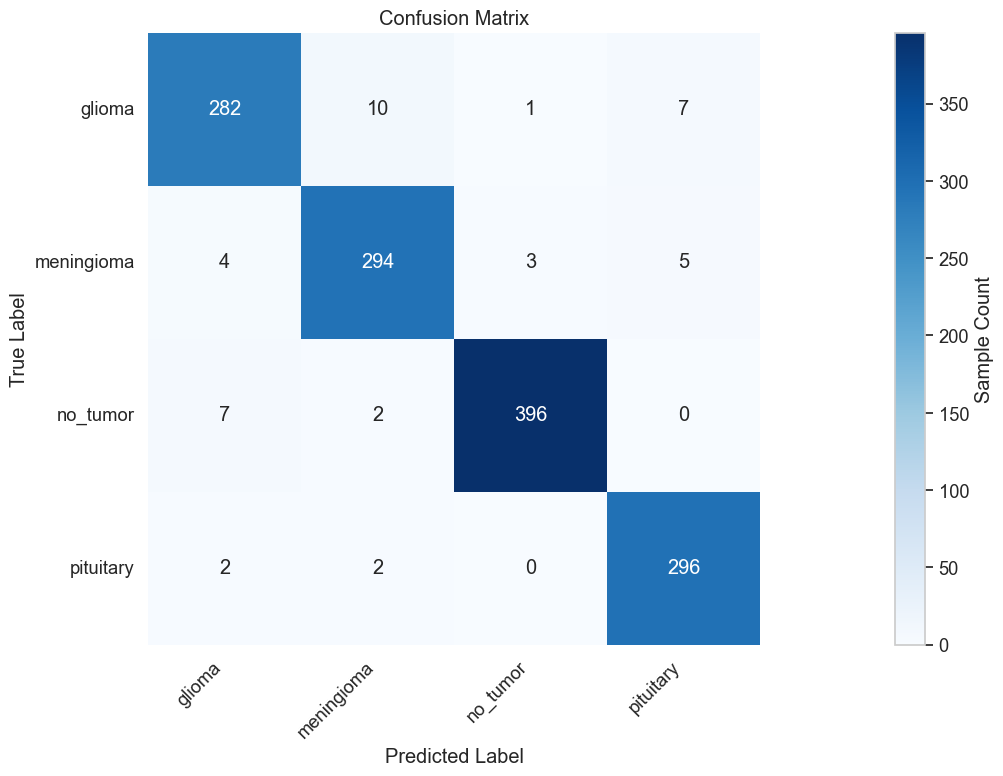

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import os

# 确保results目录存在
os.makedirs('results621', exist_ok=True)

# 1. 加载模型
print("Loading model...")
model = load_model('results621/best_global_model.h5')

# 2. 重新编译模型
print("Compiling model...")
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. 准备数据
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # 如果是one-hot编码
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# 4. 预测测试集
print("Making predictions...")
y_pred = model.predict(X_test, batch_size=8)
y_pred_labels = np.argmax(y_pred, axis=1)

# 5. 定义类别名称
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# 6. 计算混淆矩阵
print("Computing confusion matrix...")
cm = confusion_matrix(y_test_labels, y_pred_labels)

# 7. 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2, style='whitegrid')  # 设置样式
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False, square=True,
                xticklabels=class_names,
                yticklabels=class_names)

# 8. 美化图表
ax.set(xlabel='Predicted Label', ylabel='True Label',
      title='Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# 9. 添加颜色条
plt.colorbar(ax.collections[0], pad=0.15, label="Sample Count")

# 10. 保存为PDF
output_path = 'results621/confusion_matrix-15clients.pdf'
plt.savefig(output_path,
           format='pdf',
           dpi=300,
           bbox_inches='tight',
           pad_inches=0.1,
           transparent=False)

print(f"\nConfusion matrix saved to {output_path}")
plt.show()

In [22]:
# from tensorflow.keras.applications.vgg19 import VGG19
# IMG_SIZE=(200,200)
# base_model = VGG19(
#     include_top=False,
#     input_shape=IMG_SIZE + (3,),
#     weights='imagenet')

# for layer in base_model.layers:
#     layer.trainable = True

In [23]:
# base_model.summary()

In [24]:
# # Customized layers
# x = GlobalAveragePooling2D()(base_model.output)
# x = Dropout(0.4)(x)
# predict = Dense(4,activation='softmax')(x)

# # create a model object
# model = Model(inputs = base_model.input,outputs = predict)
# # model.summary()

In [25]:
# #compile our model.
# adam = Adam(learning_rate=0.0001)
# model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

Optimizer Definition:
An instance of the Adam optimizer is defined here. Adam is a widely-used optimization algorithm in deep learning, known for its efficiency and computational effectiveness. It combines the benefits of both momentum and RMSProp, and adaptively adjusts the learning rate during training. By setting learning_rate=0.0001, a relatively small learning rate is specified, which can help the model converge more stably, albeit potentially requiring more epochs to reach optimal performance.

Model Compilation:
optimizer=adam: Specifies that the previously defined Adam optimizer should be used to perform backpropagation and weight updates during training.
loss='categorical_crossentropy': Chooses "categorical crossentropy" as the loss function. This is a commonly used loss function for multi-class classification problems, particularly when the output layer uses a softmax activation. Categorical crossentropy measures the difference between two probability distributions – in this case, the true distribution of labels versus the predicted probabilities by the model.

In [26]:
# train_len = len(X_train)
# val_len = len(X_val)
# print("-----------Training Data length-----------------")
# print(train_len)

# print("-----------Validation Data length-----------------")
# print(val_len)

In [27]:
# hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),validation_data = (X_val,y_val),epochs =25,verbose=1)

### Plotting output results

In [28]:
# #Plotting the results
# acc = hist.history['accuracy']
# val_acc = hist.history['val_accuracy']
# loss = hist.history['loss']
# val_loss = hist.history['val_loss']

In [29]:
# plt.figure(figsize=(15,3))
# plt.subplot(1,2,1)
# plt.plot(acc,label='Training Accuracy')
# plt.plot(val_acc,label='Validation Accuracy')
# plt.legend(loc= "lower right")
# plt.title("Training and Validation Accuracy")

# plt.subplot(1,2,2)
# plt.plot(loss,label='Training Loss')
# plt.plot(val_loss,label='Validation Loss')
# plt.legend(loc= "upper right")
# plt.title("Training and Validation Loss")
# plt.savefig('VGGAccLoss.pdf', format='pdf')

In [30]:
# from tensorflow.keras.models import load_model

In [31]:
# #Saving the model
# model.save('bestvgg19-2.h5')

### Validation on Test set

##### Classification Report

In [32]:
loss,acc = global_model.evaluate(X_test,y_test)

41/41 [==============================] - 2s 41ms/step - loss: 0.1572 - accuracy: 0.9672


In [33]:
# from sklearn.metrics import classification_report,accuracy_score
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# predicted_classes = np.argmax(global_model.predict(X_test), axis = 1)
# print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

##### Confusion Matrix

In [34]:
# import itertools
# # pred_Y = global_model.predict(X_test, batch_size = 8, verbose = True)

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     target_names=['glioma','meningioma','no_tumor','pituitary']

#     if target_names is not None:
#         tick_marks = np.arange(len(target_names))
#         plt.xticks(tick_marks, target_names, rotation=45)
#         plt.yticks(tick_marks, target_names)
    
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

# # Predict the values from the validation dataset
# Y_pred = global_model.predict(X_test, batch_size=8)
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# # Convert validation observations to one hot vectors
# # compute the confusion matrix
# rounded_labels=np.argmax(y_test, axis=1)
# confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# # plot the confusion matrix
# plot_confusion_matrix(confusion_mtx, classes = range(4)) 
# plt.savefig('VGGCM.pdf', format='pdf')

In [35]:
# # 使用Seaborn的改进版本（无十字线+更美观）
# import seaborn as sns

# # 预测
# y_pred = global_model.predict(X_test, batch_size=8)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)

# # 混淆矩阵
# cm = confusion_matrix(y_true, y_pred_classes)
# class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# # 绘图
# plt.figure(figsize=(10,8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names,
#             cbar=False,
#             linewidths=0.5,
#             linecolor='lightgray')
# plt.title('Confusion Matrix (No Tumor)', pad=20)
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.xlabel('Predicted Label', labelpad=10)
# plt.ylabel('True Label', labelpad=10)
# plt.tight_layout()
# plt.savefig('Confusion_Matrix.pdf', bbox_inches='tight')
# plt.show()

#### Plotting sample predictions

In [36]:
# y_hat = model.predict(X_test)

# # define text labels 
# target_labels = ['glioma','meningioma','no_tumor','pituitary']

# # plot a random sample of test images, their predicted labels, and ground truth
# fig = plt.figure(figsize=(20, 8))
# for i, idx in enumerate(np.random.choice(X_test.shape[0], size=12, replace=False)):
#     ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
#     ax.imshow(np.squeeze(X_test[idx]))
#     pred_idx = np.argmax(y_hat[idx])
#     true_idx = np.argmax(y_test[idx])
#     ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
#                  color=("blue" if pred_idx == true_idx else "orange"))

In [37]:
# model = load_model('bestvgg19-2.h5')

In [38]:
# import seaborn as sns
# import pandas as pd
# from sklearn.datasets import make_classification
# from sklearn.preprocessing import label_binarize
# #from scipy import interp
# from itertools import cycle
# import pandas as pd
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

In [39]:
# y_test = np.array(y_test)

# n_classes = 4

# pred_Y = model.predict(X_test, batch_size = 16, verbose = True)
# # Plot linewidth.
# lw = 2

# # Compute ROC curve and ROC area for each class


# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
#     # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# # Plot of a ROC curve for a specific class
# for i in range(n_classes):
#     plt.figure()
#     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()

# # First aggregate all false positive rates
# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# # Then interpolate all ROC curves at this points
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# # Finally average it and compute AUC
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# # Plot all ROC curves
# fig = plt.figure(figsize=(12, 8))
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))


# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")
# sns.despine()
# plt.show()

Count Prediction time

In [40]:
# from tensorflow.keras.models import load_model
# model = load_model('bestvgg19.h5')

In [41]:
# import os
# import time
# from tensorflow.keras.preprocessing import image
# import numpy as np

# # Define the labels
# labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# # Define the directories
# directories = {
#     'glioma': './Dataset/Testingprediction/glioma',
#     'meningioma': './Dataset/Testingprediction/meningioma',
#     'notumor': './Dataset/Testingprediction/notumor',
#     'pituitary': './Dataset/Testingprediction/pituitary'
# }

# # Function to measure prediction time for images in a directory
# def measure_prediction_time(model, directory):
#     times = []
#     for img_name in os.listdir(directory):
#         img_path = os.path.join(directory, img_name)
#         img = image.load_img(img_path, target_size=(200, 200))
#         x = image.img_to_array(img)
#         x = x / 255.0
#         x = np.expand_dims(x, axis=0)
        
#         start_time = time.time()
#         predict_image = model.predict(x)
#         end_time = time.time()
        
#         prediction_time = end_time - start_time
#         times.append(prediction_time)
    
#     return times

# # Dictionary to store times for each category
# prediction_times = {}

# # Measure prediction times for each category
# for label, directory in directories.items():
#     times = measure_prediction_time(model, directory)
#     prediction_times[label] = times
#     avg_time = np.mean(times)
#     max_time = np.max(times)
#     min_time = np.min(times)
#     print(f"{label}: Average time = {avg_time:.4f} seconds, Max time = {max_time:.4f} seconds, Min time = {min_time:.4f} seconds")

# # If you want to print the overall results for all categories
# overall_times = [time for times in prediction_times.values() for time in times]
# avg_time = np.mean(overall_times)
# max_time = np.max(overall_times)
# min_time = np.min(overall_times)
# print(f"Overall: Average time = {avg_time:.4f} seconds, Max time = {max_time:.4f} seconds, Min time = {min_time:.4f} seconds")


In [42]:
# import os
# import time
# import numpy as np
# import pandas as pd
# from tensorflow.keras.preprocessing import image

# # Define the labels
# labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# # Define the directories
# directories = {
#     'glioma': './Dataset/Testingprediction/glioma',
#     'meningioma': './Dataset/Testingprediction/meningioma',
#     'notumor': './Dataset/Testingprediction/notumor',
#     'pituitary': './Dataset/Testingprediction/pituitary'
# }

# # Function to measure prediction time for images in a directory
# def measure_prediction_time(model, directory):
#     times = []
#     for img_name in os.listdir(directory):
#         img_path = os.path.join(directory, img_name)
#         img = image.load_img(img_path, target_size=(200, 200))
#         x = image.img_to_array(img)
#         x = x / 255.0
#         x = np.expand_dims(x, axis=0)
        
#         start_time = time.time()
#         predict_image = model.predict(x)
#         end_time = time.time()
        
#         prediction_time = end_time - start_time
#         times.append(prediction_time)
    
#     return times

# # Dictionary to store times for each category
# prediction_times = {}

# # Measure prediction times for each category
# for label, directory in directories.items():
#     times = measure_prediction_time(model, directory)
#     prediction_times[label] = times

# # Create a DataFrame to organize the results
# results = {
#     'Category': [],
#     'Average Time (s)': [],
#     'Max Time (s)': [],
#     'Min Time (s)': []
# }

# for label, times in prediction_times.items():
#     avg_time = np.mean(times)
#     max_time = np.max(times)
#     min_time = np.min(times)
#     results['Category'].append(label)
#     results['Average Time (s)'].append(avg_time)
#     results['Max Time (s)'].append(max_time)
#     results['Min Time (s)'].append(min_time)

# # Add overall statistics
# overall_times = [time for times in prediction_times.values() for time in times]
# avg_time = np.mean(overall_times)
# max_time = np.max(overall_times)
# min_time = np.min(overall_times)
# results['Category'].append('Overall')
# results['Average Time (s)'].append(avg_time)
# results['Max Time (s)'].append(max_time)
# results['Min Time (s)'].append(min_time)

# # Create a DataFrame and print it
# df = pd.DataFrame(results)
# print(df)
